## Quick validation of network modules

In [1]:
%load_ext autoreload
%autoreload 2
import os
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import paths

np.random.seed(1)

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
# Remove modules of this size or greater for analysis looking at coverage of regulon/operons
module_size_threshold = 1000

# Correlation threshold to determine which network modules to examine
corr_threshold_toexamine = 0.9

## Examine size of modules

In [3]:
corr_threshold_list = [0.9, 0.8, 0.7, 0.6, 0.5]

for corr_threshold in corr_threshold_list:
    print(f"Modules using correlation threshold: {corr_threshold}")
    pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
    pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

    pao1_membership = pd.read_csv(
        pao1_membership_filename, sep="\t", header=0, index_col=0
    )
    pa14_membership = pd.read_csv(
        pa14_membership_filename, sep="\t", header=0, index_col=0
    )

    print(pao1_membership["module id"].value_counts())
    print(pa14_membership["module id"].value_counts())

Modules using correlation threshold: 0.9
0.0    4530
1.0     244
2.0     170
3.0     149
4.0     127
5.0     106
6.0      84
7.0      70
8.0      51
9.0      32
Name: module id, dtype: int64
0.0    5192
1.0     391
2.0     120
3.0      81
4.0      37
6.0      35
5.0      35
Name: module id, dtype: int64
Modules using correlation threshold: 0.8
0.0     3165
1.0     1060
2.0      536
3.0      197
4.0      120
5.0       82
6.0       75
7.0       49
8.0       42
9.0       38
10.0      36
11.0      35
12.0      34
13.0      32
14.0      32
15.0      30
Name: module id, dtype: int64
0.0     3600
1.0      828
2.0      191
3.0      116
4.0       82
6.0       80
5.0       80
7.0       72
8.0       66
9.0       65
10.0      62
11.0      59
13.0      46
12.0      46
14.0      44
15.0      44
18.0      42
16.0      42
17.0      42
19.0      40
20.0      38
21.0      37
22.0      36
23.0      36
24.0      34
25.0      32
26.0      31
Name: module id, dtype: int64
Modules using correlation threshold

In [4]:
# plotting function
def plot_dist_modules(threshold_list):

    # Set up the matplotlib figure
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(len(threshold_list)):
        pao1_membership_filename = f"pao1_membership_{threshold_list[i]}.tsv"
        pa14_membership_filename = f"pa14_membership_{threshold_list[i]}.tsv"

        pao1_membership = pd.read_csv(
            pao1_membership_filename, sep="\t", header=0, index_col=0
        )
        pa14_membership = pd.read_csv(
            pa14_membership_filename, sep="\t", header=0, index_col=0
        )

        # Get bins using all data
        hist, bins_corr = np.histogram(
            np.concatenate([pao1_membership["module id"], pa14_membership["module id"]])
        )

        # Distribution plot for core genes
        fig = sns.distplot(
            pao1_membership["module id"],
            label="PAO1 modules",
            color="red",
            bins=bins_corr,
            kde=False,
            ax=axes[i],
        )

        fig = sns.distplot(
            pa14_membership["module id"],
            label="PA14 modules",
            color="blue",
            bins=bins_corr,
            kde=False,
            ax=axes[i],
        )

        fig.set_title(
            f"Histogram of size of modules using threshold {threshold_list[i]}",
            fontsize=12,
        )
        handles, labels = fig.get_legend_handles_labels()
        fig.legend(handles, labels, loc="center right")

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


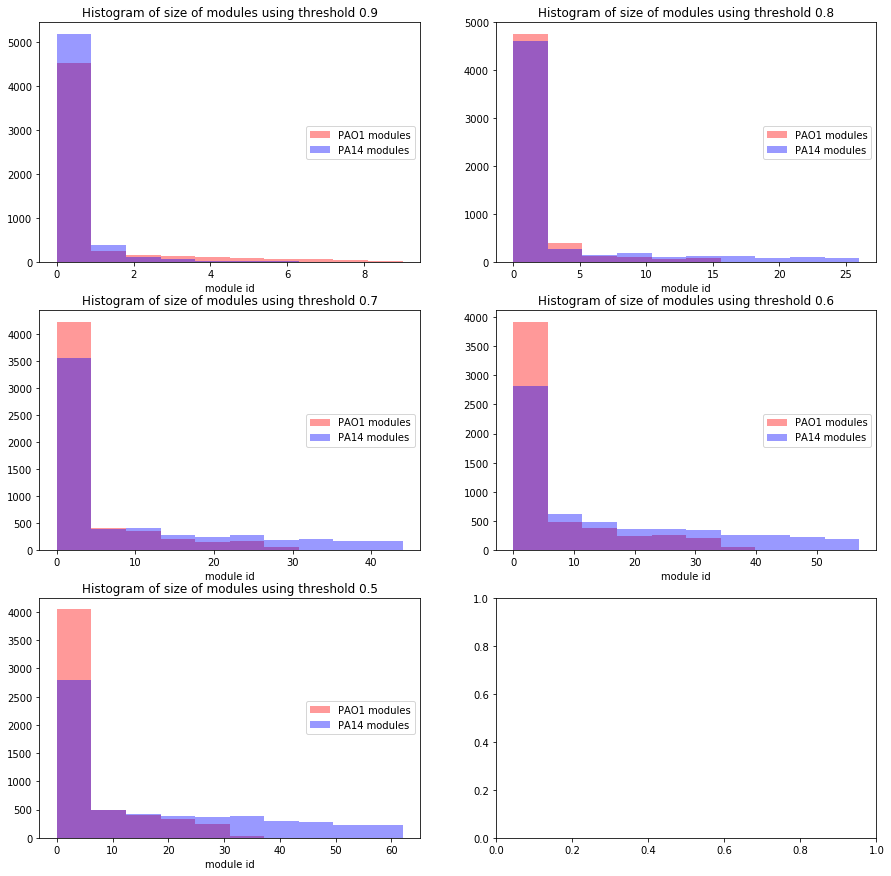

In [5]:
# Plot distribution of modules per threshold
plot_dist_modules(corr_threshold_list)

**Takeaway:**
* Looks like as we decrease our correlation threshold (i.e. connections don't need to be very strong between nodes), more modules are able to form which is what I would expect.
* Genes in PA14 are less concentrated in one large module - there are many more small modules found.

## Examine composition of modules

We expect that genes within the same operon or regulon will cluster together (i.e. be within the same module). To test this we will compare the distribution of the number of modules that contain genes within the same regulon vs the number of modules that contain random genes

_Some definitions:_

[Operons](https://en.wikipedia.org/wiki/Operon#:~:text=An%20operon%20is%20made%20up,transcription%20of%20the%20structural%20genes.) are a group of genes that share a promoter (DNA sequence that is recognized by RNA polymerase and enables transcription) and an operator (DNA sequence that repressor binds to and blocks RNA polymerase). Therefore these group of genes are transcribed or turned off together (so we would expect a very high correlation amongst these genes)

[Regulons](https://en.wikipedia.org/wiki/Regulon) are a group of genes that are regulated by the same regulatory protein. A regulon can be composed of multiple operons.

In [6]:
# Load PAO1 regulon and operon file
pao1_regulon_filename = paths.PAO1_REGULON
pao1_operon_filename = paths.PAO1_OPERON

# Load membership for specific threshold
pao1_membership_filename = f"pao1_membership_{corr_threshold_toexamine}.tsv"

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", header=0, index_col=0)

In [7]:
pao1_membership.head()

,module id
PA0001,0.0
PA0002,0.0
PA0003,0.0
PA0004,0.0
PA0005,0.0


According to Jake relationships tend to be more meaningful if the module is smaller (e.g. if an operon with 5 genes is contained in a module consisting of 10 total genes, this seems more biologically/functionally meaningful than an operon with 5 genes contained in a module consisting of 500 genes).

To correct for the single or couple very large modules, we will remove them from the analysis

In [8]:
# Get module ids that exceed size limit
module_todrop = (
    pao1_membership["module id"]
    .value_counts()[
        (pao1_membership["module id"].value_counts() > module_size_threshold)
    ]
    .index
)

print(module_todrop)

Float64Index([0.0], dtype='float64')


In [9]:
# Get genes to drop
genes_todrop = pao1_membership[pao1_membership["module id"].isin(module_todrop)].index

# Drop genes
pao1_membership = pao1_membership.drop(genes_todrop)

### Format operon/regulon files

* Remove genes from operons/regulons that don't have membership information
* Make random list of genes with matched size
* There are many single gene operons, we will remove these for this analysis

In [10]:
# Read file
pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
pao1_regulon = pd.read_csv(pao1_regulon_filename, index_col=0, header=0)

print(pao1_operon.shape)
pao1_operon.head()

(3257, 2)


,Length,Genes
OperonID,,
12029,4,PA0001;PA0002;PA0003;PA0004
12030,2,PA0005;PA0006
12031,2,PA0008;PA0009
12032,3,PA0016;PA0017;PA0018
12033,2,PA0021;PA0022


In [11]:
print(pao1_regulon.shape)
pao1_regulon.head()

(17, 2)


,Lengths,Genes
Regulon,,
Anr_regulon,72,PA5475;PA1673;PA5027;PA3337;PA4348;PA4347;PA43...
PhoB_regulon,160,PA0050;PA0051;PA0082;PA0102;PA0105;PA0165;PA01...
PvdR_regulon,14,PA2386;PA2399;PA2397;PA2396;PA2425;PA2413;PA24...
PchR_regulon,12,PA4231;PA4230;PA4229;PA4228;PA4226;PA4225;PA42...
AlgU_regulon,238,PA0059;PA0060;PA0061;PA0062;PA0071;PA0134;PA01...


In [12]:
# Convert "Genes" column from str to list
pao1_operon["Genes"] = pao1_operon["Genes"].str.split(";")
pao1_regulon["Genes"] = pao1_regulon["Genes"].str.split(";")

In [13]:
# Check if genes within operon/regulon have membership information
# Only keep genes that are found in "pao1_membership"
pao1_operon["Genes_processed"] = pao1_operon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)
pao1_regulon["Genes_processed"] = pao1_regulon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)

In [14]:
# Update length based on filtered gene list ("Genes_processed" column)
pao1_operon["Length_processed"] = pao1_operon["Genes_processed"].str.len()
pao1_regulon["Length_processed"] = pao1_regulon["Genes_processed"].str.len()

In [15]:
# If number genes in operon are 1 then remove
# Drop operons and regulons that have 0 genes due to no module filtering
pao1_operon = pao1_operon.drop(pao1_operon.query("Length_processed<=1").index)
pao1_regulon = pao1_regulon.drop(pao1_regulon.query("Length_processed<=1").index)

print(pao1_operon.shape)
print(pao1_regulon.shape)

(176, 4)
(6, 4)


In [16]:
# For each regulon/operon, select a random set of genes that are the same size at the regulon/operon
pao1_operon["Random_Genes"] = pao1_operon["Length_processed"].apply(
    lambda num_genes: pao1_membership.sample(num_genes).index.values
)
pao1_regulon["Random_Genes"] = pao1_regulon["Length_processed"].apply(
    lambda num_genes: pao1_membership.sample(num_genes).index.values
)

In [17]:
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes
OperonID,,,,,
12036,3,"[PA0029, PA0030, PA0031]","[PA0029, PA0030, PA0031]",3,"[PA1425, PA1154, PA4109]"
12039,2,"[PA0040, PA0041]","[PA0040, PA0041]",2,"[PA3291, PA0245]"
12061,2,"[PA0153, PA0154]","[PA0153, PA0154]",2,"[PA4509, PA3759]"
12066,3,"[PA0183, PA0184, PA0185]","[PA0183, PA0184, PA0185]",3,"[PA1182, PA0704, PA4513]"
12071,5,"[PA0202, PA0203, PA0204, PA0205, PA0206]","[PA0203, PA0204, PA0205, PA0206]",4,"[PA1389, PA1489, PA2681, PA1500]"


In [18]:
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes
Regulon,,,,,
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0185, PA0186, PA0285, PA4086, PA3294, PA327...",24,"[PA0528, PA0029, PA0634, PA5102, PA2046, PA067..."
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0681, PA0682, PA0884, PA0885, PA0886, PA127...",30,"[PA4169, PA3378, PA4287, PA4977, PA1278, PA222..."
LasR_regulon,183,"[PA0007, PA0026, PA0027, PA0028, PA0050, PA005...","[PA2158, PA2927, PA4652, PA4869]",4,"[PA3380, PA2036, PA4097, PA0218]"
RhlR_regulon,123,"[PA0059, PA0109, PA0132, PA0144, PA0175, PA017...","[PA1215, PA2153, PA2156, PA2163, PA2167, PA244...",7,"[PA3254, PA1280, PA0378, PA2674, PA3863, PA032..."
QscR_regulon,405,"[PA0007, PA0059, PA0105, PA0106, PA0107, PA012...","[PA0197, PA0622, PA0623, PA0628, PA0641, PA121...",43,"[PA2416, PA0599, PA1628, PA1024, PA4339, PA149..."


### Calculate the distribution

In [19]:
# For each regulon/operon get the number of modules that regulon/operon genes are found in, number of modules
# that random genes are found in
pao1_operon["Num_operon_modules"] = pao1_operon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)
pao1_operon["Num_random_modules"] = pao1_operon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

In [20]:
pao1_regulon["Num_regulon_modules"] = pao1_regulon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)
pao1_regulon["Num_random_modules"] = pao1_regulon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

In [21]:
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes,Num_operon_modules,Num_random_modules
OperonID,,,,,,,
12036,3,"[PA0029, PA0030, PA0031]","[PA0029, PA0030, PA0031]",3,"[PA1425, PA1154, PA4109]",2,3
12039,2,"[PA0040, PA0041]","[PA0040, PA0041]",2,"[PA3291, PA0245]",1,2
12061,2,"[PA0153, PA0154]","[PA0153, PA0154]",2,"[PA4509, PA3759]",2,2
12066,3,"[PA0183, PA0184, PA0185]","[PA0183, PA0184, PA0185]",3,"[PA1182, PA0704, PA4513]",1,2
12071,5,"[PA0202, PA0203, PA0204, PA0205, PA0206]","[PA0203, PA0204, PA0205, PA0206]",4,"[PA1389, PA1489, PA2681, PA1500]",2,4


In [22]:
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes,Num_regulon_modules,Num_random_modules
Regulon,,,,,,,
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0185, PA0186, PA0285, PA4086, PA3294, PA327...",24,"[PA0528, PA0029, PA0634, PA5102, PA2046, PA067...",7,7
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0681, PA0682, PA0884, PA0885, PA0886, PA127...",30,"[PA4169, PA3378, PA4287, PA4977, PA1278, PA222...",6,7
LasR_regulon,183,"[PA0007, PA0026, PA0027, PA0028, PA0050, PA005...","[PA2158, PA2927, PA4652, PA4869]",4,"[PA3380, PA2036, PA4097, PA0218]",4,4
RhlR_regulon,123,"[PA0059, PA0109, PA0132, PA0144, PA0175, PA017...","[PA1215, PA2153, PA2156, PA2163, PA2167, PA244...",7,"[PA3254, PA1280, PA0378, PA2674, PA3863, PA032...",2,5
QscR_regulon,405,"[PA0007, PA0059, PA0105, PA0106, PA0107, PA012...","[PA0197, PA0622, PA0623, PA0628, PA0641, PA121...",43,"[PA2416, PA0599, PA1628, PA1024, PA4339, PA149...",8,7


In [23]:
# Format df for plotting using displot
pao1_operon_toplot = pd.melt(
    pao1_operon, value_vars=["Num_operon_modules", "Num_random_modules"]
)
pao1_regulon_toplot = pd.melt(
    pao1_regulon, value_vars=["Num_regulon_modules", "Num_random_modules"]
)

pao1_operon_toplot.tail()

,variable,value
347,Num_random_modules,3
348,Num_random_modules,4
349,Num_random_modules,3
350,Num_random_modules,1
351,Num_random_modules,1


In [24]:
def cumulative_distribution(
    data,
    scaled=False,
    survival=False,
    label="Cumulative",
    fill=False,
    flip=False,
    preserve_ends=0,
    **kwargs,
):
    """
    plots cumulative (or survival) step distribution
    adapted from https://github.com/MarvinT/morphs/blob/master/morphs/plot/utils.py
    """
    data = np.sort(data)
    if survival:
        data = data[::-1]
    y = np.arange(data.size + 1, dtype=float)
    if scaled:
        y /= y[-1]
    x = np.concatenate([data, data[[-1]]])
    plt.step(x, y, label=label, **kwargs)
    if fill:
        plt.fill_between(x, y, alpha=0.5, step="pre", **kwargs)

Ks_2sampResult(statistic=0.34090909090909094, pvalue=1.4672459553914119e-09)

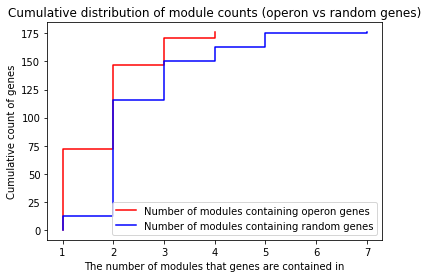

In [25]:
cumulative_distribution(
    pao1_operon["Num_operon_modules"],
    label="Number of modules containing operon genes",
    color="red",
)
cumulative_distribution(
    pao1_operon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Cumulative distribution of module counts (operon vs random genes)")
plt.ylabel("Cumulative count of genes")
plt.xlabel("The number of modules that genes are contained in")

scipy.stats.ks_2samp(
    pao1_operon["Num_operon_modules"], pao1_operon["Num_random_modules"]
)

Text(0.5, 1.0, 'PMF distribution of module counts (operon vs random genes)')

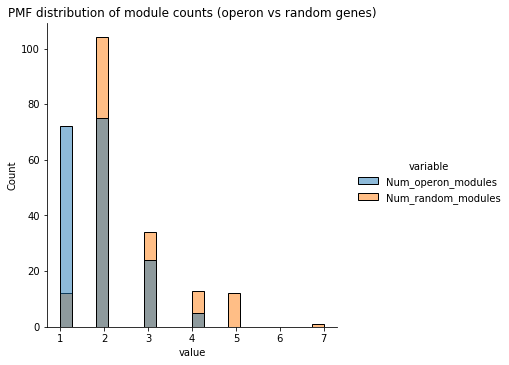

In [26]:
fig = sns.displot(
    pao1_operon_toplot,
    x="value",
    hue="variable",
)
plt.title("PMF distribution of module counts (operon vs random genes)")

Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.8095573106166531)

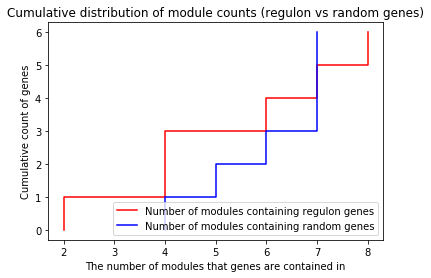

In [27]:
cumulative_distribution(
    pao1_regulon["Num_regulon_modules"],
    label="Number of modules containing regulon genes",
    color="red",
)
cumulative_distribution(
    pao1_regulon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Cumulative distribution of module counts (regulon vs random genes)")
plt.ylabel("Cumulative count of genes")
plt.xlabel("The number of modules that genes are contained in")

scipy.stats.ks_2samp(
    pao1_regulon["Num_regulon_modules"], pao1_regulon["Num_random_modules"]
)

Text(0.5, 1.0, 'PMF distribution of module counts (regulon vs random genes)')

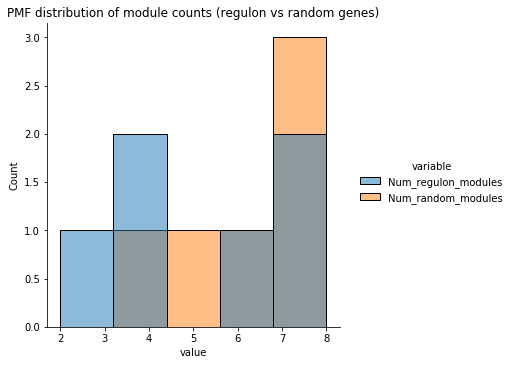

In [28]:
fig = sns.displot(
    pao1_regulon_toplot,
    x="value",
    hue="variable",
)
plt.title("PMF distribution of module counts (regulon vs random genes)")

### Check what size the modules are that regulon/operon/random genes are found in

In [31]:
pao1_operon["operon_module_ids"] = pao1_operon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_operon["random_module_ids"] = pao1_operon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes,Num_operon_modules,Num_random_modules,operon_module_ids,random_module_ids
OperonID,,,,,,,,,
12036,3,"[PA0029, PA0030, PA0031]","[PA0029, PA0030, PA0031]",3,"[PA1425, PA1154, PA4109]",2,3,"[2.0, 4.0]","[2.0, 8.0, 5.0]"
12039,2,"[PA0040, PA0041]","[PA0040, PA0041]",2,"[PA3291, PA0245]",1,2,[1.0],"[8.0, 1.0]"
12061,2,"[PA0153, PA0154]","[PA0153, PA0154]",2,"[PA4509, PA3759]",2,2,"[7.0, 4.0]","[2.0, 1.0]"
12066,3,"[PA0183, PA0184, PA0185]","[PA0183, PA0184, PA0185]",3,"[PA1182, PA0704, PA4513]",1,2,[5.0],"[5.0, 1.0]"
12071,5,"[PA0202, PA0203, PA0204, PA0205, PA0206]","[PA0203, PA0204, PA0205, PA0206]",4,"[PA1389, PA1489, PA2681, PA1500]",2,4,"[7.0, 3.0]","[8.0, 1.0, 5.0, 4.0]"


In [32]:
pao1_membership["module id"].value_counts()

1.0    244
2.0    170
3.0    149
4.0    127
5.0    106
6.0     84
7.0     70
8.0     51
9.0     32
Name: module id, dtype: int64

In [30]:
pao1_regulon["regulon_module_ids"] = pao1_regulon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_regulon["random_module_ids"] = pao1_regulon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes,Num_regulon_modules,Num_random_modules,regulon_module_ids,random_module_ids
Regulon,,,,,,,,,
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0185, PA0186, PA0285, PA4086, PA3294, PA327...",24,"[PA0528, PA0029, PA0634, PA5102, PA2046, PA067...",7,7,"[5.0, 3.0, 8.0, 6.0, 4.0, 1.0, 2.0]","[4.0, 2.0, 9.0, 5.0, 1.0, 3.0, 7.0]"
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0681, PA0682, PA0884, PA0885, PA0886, PA127...",30,"[PA4169, PA3378, PA4287, PA4977, PA1278, PA222...",6,7,"[4.0, 1.0, 3.0, 6.0, 7.0, 5.0]","[4.0, 3.0, 1.0, 2.0, 8.0, 5.0, 6.0]"
LasR_regulon,183,"[PA0007, PA0026, PA0027, PA0028, PA0050, PA005...","[PA2158, PA2927, PA4652, PA4869]",4,"[PA3380, PA2036, PA4097, PA0218]",4,4,"[1.0, 6.0, 4.0, 7.0]","[4.0, 8.0, 2.0, 3.0]"
RhlR_regulon,123,"[PA0059, PA0109, PA0132, PA0144, PA0175, PA017...","[PA1215, PA2153, PA2156, PA2163, PA2167, PA244...",7,"[PA3254, PA1280, PA0378, PA2674, PA3863, PA032...",2,5,"[6.0, 1.0]","[1.0, 2.0, 7.0, 3.0, 5.0]"
QscR_regulon,405,"[PA0007, PA0059, PA0105, PA0106, PA0107, PA012...","[PA0197, PA0622, PA0623, PA0628, PA0641, PA121...",43,"[PA2416, PA0599, PA1628, PA1024, PA4339, PA149...",8,7,"[5.0, 9.0, 1.0, 6.0, 8.0, 4.0, 2.0, 7.0]","[6.0, 5.0, 1.0, 3.0, 2.0, 7.0, 4.0]"


_About cumulative distribution plots:_
* The axis cumulative distribution plots are:
    * y-axis = The cumulative count of genes within operon/regulon (red) or random genes (blue).
    * x-axis = The number of modules that genes are contained in

* Looking at the operon plot, the value at "1" on the x-axis says that there are ~3000 operon genes found in exactly 1 module, and there are ~2700 random genes found in exactly 1 module
    * Then the increase at "2" on the x-axis is the number of operons or random genes that are spread across 2 or 1 different modules (this is the cumulative part). In other words, a random set (size matched with the operon) where the genes in that set are found in 2 modules.
    * There are >3000 operon genes that are found in either 1 or 2 modules. There are > 3000 random genes that are found in either 1 or 2 modules.
    * Then if you compare the blue and the red curves, the vertical distance between the two curves tells you how much of a shift there is between the distributions.
* These distribution plots are summing counts as you move from left to right, so a shift in the curves corresponds to a shift in the distribution (i.e. a curve shifted to the right means that the distribution is shifted to the right)

**Takeaway:**
* We can perform [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to compare the distribution of module counts for genes in regulons/operons versus random genes. The KS test will quantify the difference in the cumulative distribution curves.

* Based on the KS test, there is a significant difference (across thresholds) between the operon and random distribution, as we would expect.
    * There is only a significant difference between the regulon and random distributions at lower thresholds (0.7 and below). The lack of significance at higher thresholds is likely due to the small sample size (i.e. 6 or 10 regulons have genes that are contained in modules with fewer than 1000 genes)